In [1]:
import torch
import torchvision

This cell defines a composition of image transformations using `transforms.Compose`. Let's break down each transformation:

*   **`transforms.ToImage()`:** This converts the input tensor into a PIL image. This is necessary if your input data isn't already in PIL Image format.

*   **`transforms.ToDtype(torch.float32, scale=True)`:** This converts the image's data type to `torch.float32`. The `scale=True` argument ensures that the values are scaled to the range [0, 1] before the conversion.  This is important for numerical stability and compatibility with many machine learning models.

*   **`transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))`:** This normalizes the image by subtracting the mean and dividing by the standard deviation for each color channel (R, G, B).  Using a mean of (0.5, 0.5, 0.5) and a standard deviation of (0.5, 0.5, 0.5) centers the data around 0 with a standard deviation of 1. This is a common preprocessing step for image classification models and can improve model performance and training stability.

The `transform` object can now be applied to images using `transform(image)`.  This will apply all three transformations in sequence.


In [2]:
import torchvision.transforms.v2 as transforms
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)) 
])

Downloading Test and Train Datasets 


In [3]:
train_data = torchvision.datasets.CIFAR10(root="../../Datasets/Cifar10",download=True,train=True,transform=transform)
test_data = torchvision.datasets.CIFAR10(root="../../Datasets/Cifar10",download=True,train=False,transform=transform)

DataLoaders

In [4]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32, shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=32, shuffle=True,num_workers=2)

Get Image and lables from data

the size of the image is explained in this order #channels, (#pixels,#pixels)

In [5]:
image, label = train_data[0]
image.size()

torch.Size([3, 32, 32])

The dataset encodes the labels as a range 0-9, to get the meanings for these numbers, cifar provides a batch.meta file which has the meaning of that range

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='ASCII')
    return dict

labels_names = unpickle("../../Datasets/Cifar10/cifar-10-batches-py/batches.meta").get('label_names')

print(labels_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



This code defines a convolutional neural network (CNN) for image classification using PyTorch.
self.conv1 = Conv2d(in_channels=3, out_channels=12, kernel_size=5): This creates the first convolutional layer.

in_channels=3: The input to this layer has 3 channels (likely representing the red, green, and blue components of an RGB image).
out_channels=12: This layer produces 12 feature maps (outputs).
kernel_size=5: The convolutional filters are 5x5 pixels.

self.pool = MaxPool2d(kernel_size=2): This is a max pooling layer with a 2x2 kernel. 
Max pooling reduces the spatial dimensions of the feature maps, making the network less sensitive to small variations in the input and reducing computational cost.

self.conv2 = Conv2d(in_channels=12, out_channels=24, kernel_size=5): The second convolutional layer.

in_channels=12: The input comes from the previous convolutional layer (12 feature maps).
out_channels=24: This layer produces 24 feature maps.
kernel_size=5: Again, 5x5 filters.

self.fully_connected1 = Linear(in_features=24*5*5, out_features=120): The first fully connected (dense) layer.

in_features=24*5*5: This calculates the input size. After two convolutional and pooling layers, assuming a standard image size and no padding, the feature maps would likely have dimensions 5x5. Since there are 24 feature maps from conv2, the total input size is 24 * 5 * 5 = 600.
out_features=120: This layer produces 120 outputs.

self.fully_connected2 = Linear(in_features=120, out_features=80): The second fully connected layer.
in_features=120: Input from the previous fully connected layer.
out_features=80: Produces 80 outputs.

self.fully_connected3 = Linear(in_features=80, out_features=10): The final fully connected layer.
in_features=80: Input from the previous fully connected layer.
out_features=10: This likely represents 10 output classes for a classification task (e.g., classifying images into 10 categories).

forward(self, x): This defines the forward pass of the network. It specifies how the input x flows through the layers.

The code applies convolutional layers (conv1, conv2), followed by max pooling (pool), ReLU activation functions (relu), and finally fully connected layers (fully_connected1, fully_connected2, fully_connected3).
Flatten() converts the multi-dimensional output of the convolutional layers into a 1D vector before feeding it to the fully connected layers.
The final layer produces the network's output. This output would then typically be passed through a softmax function to obtain probabilities for each of the 10 classes.


In [92]:
from torch.nn import Module , Conv2d, Linear, MaxPool2d, Flatten
from torch.nn.functional import relu

class NeuralNet(Module):
    def __init__(self):
        super().__init__()
        self.pool = MaxPool2d(2,2) 
        self.flatten = Flatten(1)
        self.conv1 = Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.conv2 = Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv3 = Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        
        self.fully_connected1  = Linear(in_features= 64*4*4, out_features=64 )
        self.fully_connected2  = Linear(in_features= 64, out_features= 32 )
        self.fully_connected3  = Linear(in_features= 32, out_features=10 )

    def forward(self,x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = (relu(self.conv3(x)))
        x = self.flatten(x)
        x = relu(self.fully_connected1(x))
        x = relu(self.fully_connected2(x))
        x = self.fully_connected3(x)
        return x
        

In [93]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD,Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("devide used: ",device)
cnn = NeuralNet().to(torch.device(device))
loss_function = CrossEntropyLoss()
optimizier = Adam(params = cnn.parameters(), lr=0.001)


devide used:  cuda


Here's a breakdown of the steps involved:

1.  **Setting Up Training Rounds (Epochs):** The process begins by establishing how many times the model will learn from the entire training dataset. Each complete pass through the data is called an "epoch," and in this case, there are 50 of them.
2.  **Preparing for Each Round:** Before each epoch, we reset a counter that tracks the "loss." Loss, in this context, is a measure of how wrong the model's predictions are. We start with a loss of zero at the start of each epoch, and we will add to it during the epoch.
3.  **Processing the Data in Batches:** The training data is too large to process all at once, so it's divided into smaller chunks called "batches." The model will learn from each batch in turn.
4.  **Getting a Batch of Data:** For each batch, the code grabs the training data and its associated labels (the correct answers).
5.  **Clearing Previous Learning:** Before learning from a new batch, the model "forgets" what it learned from the previous one by resetting some internal values called "gradients." This ensures that each batch contributes independently to the overall learning.
6.  **Making Predictions:** The model takes the batch of training data and makes predictions. These predictions are its best guess based on what it currently knows.
7.  **Measuring the Mistake (Loss):** The model's predictions are compared to the correct answers (labels) to determine how wrong it was. This difference is the "loss," and the goal is to minimize it.
8. **Calculating the Adjustment:** Using the "loss," the model calculates the change it needs to make to improve its predictions. This is done through a complex mathematical process.
9.  **Updating the Model:** The model adjusts its internal settings based on the calculated changes. This is where the actual learning takes place. The model is now slightly better than before at making predictions.
10. **Keeping Track of Mistakes:** The "loss" from each batch is added to the running total. This helps us understand how well the model is doing overall in the current epoch.
11. **Repeating for All Batches:** Steps 4 through 10 are repeated for every batch in the training dataset.
12. **Calculating Average Mistakes per Round:** Once all batches in an epoch are processed, the code calculates the average "loss" for that epoch. This is done by dividing the total loss by the number of batches.
13. **Reporting Progress:** The average loss is then displayed. This is a key indicator of how well the model is learning. The goal is for the average loss to decrease over successive epochs.
14. **Repeating for All Rounds:** Steps 2 through 13 are repeated for each of the 50 training epochs.



In [94]:
for epoch in range(50):
    print("Training epoch number: ",epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))
        optimizier.zero_grad()
        ouputs = cnn(inputs)
        loss = loss_function(ouputs,labels)
        loss.backward()
        optimizier.step()
        
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(train_loader):.4f}")

Training epoch number:  0
Loss: 1.5410
Training epoch number:  1
Loss: 1.1937
Training epoch number:  2
Loss: 1.0205
Training epoch number:  3
Loss: 0.8971
Training epoch number:  4
Loss: 0.8122
Training epoch number:  5
Loss: 0.7468
Training epoch number:  6
Loss: 0.6954
Training epoch number:  7
Loss: 0.6513
Training epoch number:  8
Loss: 0.6158
Training epoch number:  9
Loss: 0.5827
Training epoch number:  10
Loss: 0.5438
Training epoch number:  11
Loss: 0.5146
Training epoch number:  12
Loss: 0.4901
Training epoch number:  13
Loss: 0.4667
Training epoch number:  14
Loss: 0.4383
Training epoch number:  15
Loss: 0.4213
Training epoch number:  16
Loss: 0.3934
Training epoch number:  17
Loss: 0.3727
Training epoch number:  18
Loss: 0.3567
Training epoch number:  19
Loss: 0.3472
Training epoch number:  20
Loss: 0.3225
Training epoch number:  21
Loss: 0.3087
Training epoch number:  22
Loss: 0.2971
Training epoch number:  23
Loss: 0.2817
Training epoch number:  24
Loss: 0.2713
Training e

You usually want to stop when the error doesnt decrease in a meaningful way or when you reached the final epoch set as a hyperparameter. 
Sometimes, a mix of those strategies is better than a single one

Save the model so that we dont do the training every time we want to test the model

In [95]:
torch.save(cnn.state_dict(),'cifar10.pth')

To load it we do as following:

In [96]:
loaded_cnn = NeuralNet().to(torch.device('cuda'))
loaded_cnn.load_state_dict(torch.load('cifar10.pth'))

<All keys matched successfully>

We now test the the model

In [143]:
correct = 0
total = 0

loaded_cnn.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))
        outputs = loaded_cnn(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()
final_accuracy = 100 * (correct/total)

In [144]:
print(f"Final accuracy of the model: {final_accuracy}%")

Final accuracy of the model: 69.17%


Now we get some images from google that we know what labels are, its better that those images are not present in the dataset.
However, since the images do not respect the size of the images used to train the model, we have to transform them in a compatible format.
we could either download them or use some python libraries that do that for using web scraping (google api are deprecated, so using other libraries is adviced)

In [145]:
transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)) 
])

In [146]:
import os
import random
from PIL import Image 

def load_random_image(folder_path):
    """
    Loads a random image from a specified folder.

    Args:
        folder_path: The path to the folder containing images.

    Returns:
        A PIL Image object if successful, None otherwise.
    """
    try:
        # 1. Get a list of all files in the folder
        file_list = os.listdir(folder_path)

        # 2. Filter for image files (you can customize extensions)
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_files = [f for f in file_list if f.lower().endswith(image_extensions)]

        # 3. Error Handling: Check if there are any image files
        if not image_files:
            print(f"Error: No image files found in '{folder_path}'.")
            return None

        # 4. Choose a random image file
        random_image_file = random.choice(image_files)


        # 5. Construct the full path to the image
        image_path = os.path.join(folder_path, random_image_file)

        # 6. Load the image using PIL
        image = Image.open(image_path)
        display(image)
        
        # 7.transform the image so that is compatible
        image = transform_test(image)
        image = image.unsqueeze(0) # so that we present the image as a batch of 1 image 

        
        # 9. Return the image
        return image

    except FileNotFoundError:
        print(f"Error: Folder not found: '{folder_path}'.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None





In [147]:
# Example Usage:
folder_path = "./test_images/" 


Gotta find a solution for custom images, maybe i saved them wrong. 

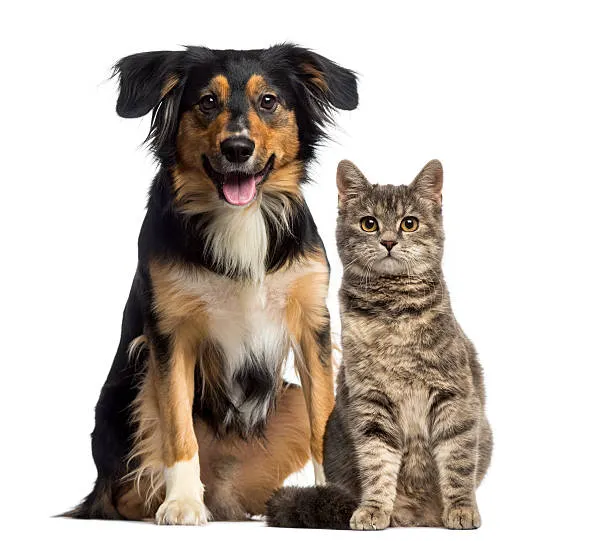

Predicted label: horse


In [151]:


with torch.no_grad():
        random_image = load_random_image(folder_path).to(torch.device('cuda'))
        output = loaded_cnn(random_image)
        _, predicted = torch.max(output,1)
        print(f"Predicted label: {labels_names[predicted.item()]}")
        
    

Using the test set for the results however is quite accurate

Test set accuracy = 69.17 %


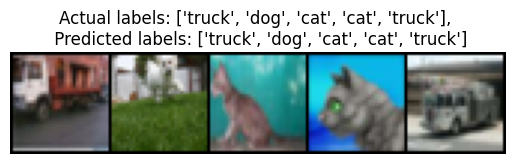

In [159]:
import matplotlib.pyplot as plt
import numpy as np

test_acc=0
loaded_cnn.eval() 
  
with torch.no_grad(): 
    #Iterating over the training dataset in batches 
    for i, (images, labels) in enumerate(test_loader): 
          
        images = images.to(device) 
        labels = labels.to(device) 
          
        #Calculating outputs for the batch being iterated 
        outputs = loaded_cnn(images) 
          
        #Calculated prediction labels from models 
        _, predicted = torch.max(outputs.data, 1) 
          
        #Comparing predicted and true labels 
        test_acc += (predicted == labels).sum().item() 
      
    print(f"Test set accuracy = {100 * test_acc / len(test_data)} %")

num_images = 5
labels_name = [labels_names[labels[idx]] for idx in range(num_images)]  
predicted = [labels_names[predicted[idx]] for idx in range(num_images)]  
  
#Generating the title for the plot 
title = f"Actual labels: {labels_name}, \n Predicted labels: {predicted}"
  
#Finally plotting the images with their actual and predicted labels in the title 
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0))) 
plt.title(title) 
plt.axis("off")
plt.show()